In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten
from tensorflow.keras.metrics import Accuracy, binary_crossentropy
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Ftrl, Nadam
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.models import load_model, save_model

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import xgboost as xgb

2024-06-06 11:35:10.431368: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-06 11:35:10.431496: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-06 11:35:10.558454: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Get data

In [2]:
# Load the dataset
train_path = '/kaggle/input/dsaa-6100-titanic-dicision_tree/train.csv'
test_path = '/kaggle/input/dsaa-6100-titanic-dicision_tree/test.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
print(train_df.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


In [3]:
print(train_df.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [4]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [5]:
print(train_df['Survived'].value_counts())

Survived
0    549
1    342
Name: count, dtype: int64


In [6]:
# Save test_ids for submission
test_ids = test_df.pop('PassengerId')
train_df = train_df.drop(['PassengerId'], axis=1)

print(test_ids[:2], '\n', test_ids[-2:])

0    892
1    893
Name: PassengerId, dtype: int64 
 416    1308
417    1309
Name: PassengerId, dtype: int64


# Preprocessing

In [7]:
for col in train_df.drop('Survived', axis=1).columns:
    print(train_df[col].dtype)

int64
object
object
float64
int64
int64
object
float64
object
object


In [8]:
# Check for missing values
print(train_df.isnull().sum())

for col in train_df.columns:
    if train_df[col].isna().sum() >= 0.2*train_df.shape[0]:
        train_df = train_df.drop(col, axis=1)
        test_df = test_df.drop(col, axis=1)
        print(f'Column {col} is dropped from train dataframe.')

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64
Column Cabin is dropped from train dataframe.


In [9]:
mode = train_df['Age'].mode()[0]
train_df['Age'] = train_df['Age'].fillna(mode)
test_df['Age'] = test_df['Age'].fillna(mode)
print(f'NaN values in column "Age" are replaced with mode = {mode}.')

                                            
mean = train_df['Fare'].mean()
train_df['Fare'] = train_df['Fare'].fillna(mean)
test_df['Fare'] = test_df['Fare'].fillna(mean)
print(f'NaN values in column "Fare" are replaced with mean = {mean}.')                                

if train_df.isna().sum().any():
    print('There are still NaN values in train dataframe.')
else:
    print('No more NaN values in train dataframe.')

NaN values in column "Age" are replaced with mode = 24.0.
NaN values in column "Fare" are replaced with mean = 32.204207968574636.
There are still NaN values in train dataframe.


In [10]:
train_df.isna().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Embarked    2
dtype: int64

In [11]:
test_df.isna().sum()

Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Embarked    0
dtype: int64

In [12]:
# One Hot Encoding (OHE) for categorical columns
train_df = pd.get_dummies(train_df, columns=['Sex'])
test_df = pd.get_dummies(test_df, columns=['Sex'])

# Convert boolean columns to int
bool_col = [var for var in train_df.columns if train_df[var].dtypes == 'bool']
train_df[bool_col] = train_df[bool_col].astype('int64')
test_df[bool_col] = test_df[bool_col].astype('int64')

# Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton
label_encoder = LabelEncoder()
train_df['Embarked'] = label_encoder.fit_transform(train_df['Embarked'])
test_df['Embarked'] = label_encoder.transform(test_df['Embarked'])

# socio-economic status (SES): Ticket class	1 = 1st = Upper, 2 = 2nd = Middle, 3 = 3rd = Lower
ordinal_encoder = OrdinalEncoder()
train_df['Pclass'] = ordinal_encoder.fit_transform(train_df['Pclass'].values.reshape(-1, 1))
test_df['Pclass'] = ordinal_encoder.transform(test_df['Pclass'].values.reshape(-1, 1))

# Remove columns from the data
train_df = train_df.drop(['Name', 'Ticket'], axis=1)
test_df = test_df.drop(['Name', 'Ticket'], axis=1)

# Split the data into training and validation sets
train_ds, val_ds = train_test_split(train_df, test_size=0.2)
train_ds.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,Sex_female,Sex_male
19,1,2.0,24.0,0,0,7.2250,0,1,0
639,0,2.0,24.0,1,0,16.1000,2,0,1
566,0,2.0,19.0,0,0,7.8958,2,0,1
780,1,2.0,13.0,0,0,7.2292,0,1,0
599,1,0.0,49.0,1,0,56.9292,0,0,1


In [13]:
train_df.isna().sum()

Survived      0
Pclass        0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked      0
Sex_female    0
Sex_male      0
dtype: int64

In [14]:
train_df['Embarked'].unique()

array([2, 0, 1, 3])

In [15]:
print(train_df.head())

   Survived  Pclass   Age  SibSp  Parch     Fare  Embarked  Sex_female  \
0         0     2.0  22.0      1      0   7.2500         2           0   
1         1     0.0  38.0      1      0  71.2833         0           1   
2         1     2.0  26.0      0      0   7.9250         2           1   
3         1     0.0  35.0      1      0  53.1000         2           1   
4         0     2.0  35.0      0      0   8.0500         2           0   

   Sex_male  
0         1  
1         0  
2         0  
3         0  
4         1  


In [16]:
print(test_df.head())

   Pclass   Age  SibSp  Parch     Fare  Embarked  Sex_female  Sex_male
0     2.0  34.5      0      0   7.8292         1           0         1
1     2.0  47.0      1      0   7.0000         2           1         0
2     1.0  62.0      0      0   9.6875         1           0         1
3     2.0  27.0      0      0   8.6625         2           0         1
4     2.0  22.0      1      1  12.2875         2           1         0


In [17]:
# Split the data into input and target
train_target = train_ds.pop("Survived").replace({'0': 0, '1': 1}).astype('float32').values
val_target = val_ds.pop("Survived").replace({'0': 0, '1': 1}).astype('float32').values
print(train_target[:5])

[1. 0. 0. 1. 1.]


In [18]:
# Scaling the data
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()
robust_scaler = RobustScaler()

# Model 0 Random forest classifier with standard scaler

In [19]:
params = {
    'randomforestclassifier__n_estimators': [100, 200, 300, 400, 500],
    'randomforestclassifier__max_depth': [6, 8, None],
    'randomforestclassifier__max_features': [None, 'sqrt', 'log2'],
    'randomforestclassifier__min_samples_split': [2, 4, 0.01, 0.02],
    'randomforestclassifier__min_samples_leaf': [1, 2, 0.01, 0.02],
    'randomforestclassifier__criterion':['gini', 'entropy', 'log_loss'],
    'randomforestclassifier__bootstrap': [True, False]
}

RF_N_ITER = 200
rf_model = RandomForestClassifier()
random_search = RandomizedSearchCV(estimator=make_pipeline(standard_scaler, rf_model),
                                   param_distributions=params,
                                   n_jobs=None,
                                   n_iter=RF_N_ITER,
                                   cv=5,
                                   scoring='accuracy')
random_search.fit(train_ds, train_target)

standard_rf_model = random_search.best_estimator_
print(f"Best parameters: {random_search.best_params_}")

preds_rf = standard_rf_model.predict(val_ds)
standard_rf_accuracy = accuracy_score(preds_rf, val_target)
print(f"Random Forest with Standard Scaler Accuracy: {standard_rf_accuracy}")

# Predict on test dataframe
standard_rf_preds = standard_rf_model.predict(test_df)

Best parameters: {'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__min_samples_split': 0.01, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__max_features': None, 'randomforestclassifier__max_depth': None, 'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__bootstrap': True}
Random Forest with Standard Scaler Accuracy: 0.8044692737430168


# Model 1 Random forest classifier with minmax scaler

In [20]:
random_search = RandomizedSearchCV(estimator=make_pipeline(minmax_scaler, rf_model),
                                   param_distributions=params,
                                   n_jobs=None,
                                   n_iter=RF_N_ITER,
                                   cv=5,
                                   scoring='accuracy')
random_search.fit(train_ds, train_target)

minmax_rf_model = random_search.best_estimator_
print(f"Best parameters: {random_search.best_params_}")

preds_rf = minmax_rf_model.predict(val_ds)
minmax_rf_accuracy = accuracy_score(preds_rf, val_target)
print(f"Random Forest with MinMax Scaler Accuracy: {minmax_rf_accuracy}")

# Predict on test dataframe
minmax_rf_preds = minmax_rf_model.predict(test_df)

Best parameters: {'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__min_samples_split': 0.02, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__max_features': None, 'randomforestclassifier__max_depth': None, 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__bootstrap': True}
Random Forest with MinMax Scaler Accuracy: 0.7877094972067039


# Model 2 Random forest classifier with robust scaler

In [21]:
random_search = RandomizedSearchCV(estimator=make_pipeline(robust_scaler, rf_model),
                                   param_distributions=params,
                                   n_jobs=None,
                                   n_iter=RF_N_ITER,
                                   cv=5,
                                   scoring='accuracy')
random_search.fit(train_ds, train_target)

robust_rf_model = random_search.best_estimator_
print(f"Best parameters: {random_search.best_params_}")

preds_rf = robust_rf_model.predict(val_ds)
robust_rf_accuracy = accuracy_score(preds_rf, val_target)
print(f"Random Forest with Robust Scaler Accuracy: {robust_rf_accuracy}")

# Predict on test dataframe
robust_rf_preds = robust_rf_model.predict(test_df)

Best parameters: {'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__min_samples_split': 0.01, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__max_features': None, 'randomforestclassifier__max_depth': None, 'randomforestclassifier__criterion': 'log_loss', 'randomforestclassifier__bootstrap': True}
Random Forest with Robust Scaler Accuracy: 0.8156424581005587


# Model 3 SVM classifier with standard scaler

In [22]:
params = [
    {
        'svc__C': [0.1, 1, 10, 100],
        'svc__kernel': ['poly'],
        'svc__degree': [2, 3],
        'svc__gamma': ['scale', 'auto'],
        'svc__coef0': np.arange(0.1, 1, 0.2),
        'svc__shrinking': [True, False],
        'svc__tol': [1e-2, 1e-3, 1e-4],
    },
    {
        'svc__C': [0.1, 1, 10, 100],
        'svc__kernel': ['sigmoid'],
        'svc__gamma': ['scale', 'auto'],
        'svc__coef0': np.arange(0.1, 1, 0.2),
        'svc__shrinking': [True, False],
        'svc__tol': [1e-2, 1e-3, 1e-4],
    },
    {
        'svc__C': [0.1, 1, 10, 100],
        'svc__kernel': ['linear'],
        'svc__shrinking': [True, False],
        'svc__tol': [1e-2, 1e-3, 1e-4],
    },
    {
        'svc__C': [0.1, 1, 10, 100],
        'svc__kernel': ['rbf'],
        'svc__gamma': ['scale', 'auto'],
        'svc__shrinking': [True, False],
        'svc__tol': [1e-2, 1e-3, 1e-4],
    }
]

SVM_N_ITER = 40
svc_model = SVC()
random_search = RandomizedSearchCV(estimator=make_pipeline(standard_scaler, svc_model),
                                   param_distributions=params,
                                   n_jobs=None,
                                   n_iter=SVM_N_ITER,
                                   cv=5,
                                   scoring='accuracy')
random_search.fit(train_ds, train_target)

standard_svc_model = random_search.best_estimator_
print(f"Best parameters: {random_search.best_params_}")

preds_svc = standard_svc_model.predict(val_ds)
standard_svc_accuracy = accuracy_score(preds_svc, val_target)
print(f"SVC with Standard Scaler Accuracy: {standard_svc_accuracy}")

standard_svc_preds = standard_svc_model.predict(test_df)

Best parameters: {'svc__tol': 0.001, 'svc__shrinking': True, 'svc__kernel': 'poly', 'svc__gamma': 'scale', 'svc__degree': 3, 'svc__coef0': 0.30000000000000004, 'svc__C': 0.1}
SVC with Standard Scaler Accuracy: 0.7988826815642458


# Model 4 SVM classifier with minmax scaler

In [23]:
random_search = RandomizedSearchCV(estimator=make_pipeline(minmax_scaler, svc_model),
                                   param_distributions=params,
                                   n_jobs=None,
                                   n_iter=SVM_N_ITER,
                                   cv=5,
                                   scoring='accuracy')
random_search.fit(train_ds, train_target)

minmax_svc_model = random_search.best_estimator_
print(f"Best parameters: {random_search.best_params_}")

preds_svc = minmax_svc_model.predict(val_ds)
minmax_svc_accuracy = accuracy_score(preds_svc, val_target)
print(f"SVC with MinMax Scaler Accuracy: {minmax_svc_accuracy}")

minmax_svc_preds = minmax_svc_model.predict(test_df)

Best parameters: {'svc__tol': 0.01, 'svc__shrinking': False, 'svc__kernel': 'poly', 'svc__gamma': 'scale', 'svc__degree': 3, 'svc__coef0': 0.7000000000000001, 'svc__C': 10}
SVC with MinMax Scaler Accuracy: 0.7932960893854749


# Model 5 SVM classifier with robust scaler

In [24]:
random_search = RandomizedSearchCV(estimator=make_pipeline(robust_scaler, svc_model),
                                   param_distributions=params,
                                   n_jobs=None,
                                   n_iter=SVM_N_ITER,
                                   cv=5,
                                   scoring='accuracy')
random_search.fit(train_ds, train_target)

robust_svc_model = random_search.best_estimator_
print(f"Best parameters: {random_search.best_params_}")

preds_svc = robust_svc_model.predict(val_ds)
robust_svc_accuracy = accuracy_score(preds_svc, val_target)
print(f"SVC with Robust Scaler Accuracy: {robust_svc_accuracy}")

robust_svc_preds = robust_svc_model.predict(test_df)

Best parameters: {'svc__tol': 0.0001, 'svc__shrinking': True, 'svc__kernel': 'poly', 'svc__gamma': 'auto', 'svc__degree': 2, 'svc__coef0': 0.30000000000000004, 'svc__C': 1}
SVC with Robust Scaler Accuracy: 0.8044692737430168


# Model 6 KNN classifier with standard scaler

In [25]:
params = [
    {
        'kneighborsclassifier__n_neighbors': np.arange(2, 31),
        'kneighborsclassifier__weights': ['uniform', 'distance'],
        'kneighborsclassifier__algorithm': ['ball_tree', 'kd_tree'],
        'kneighborsclassifier__p': [1, 2, 3],
        'kneighborsclassifier__leaf_size': np.arange(20, 51, 10),
        'kneighborsclassifier__metric': ['minkowski']
    },
    {
        'kneighborsclassifier__n_neighbors': np.arange(2, 31),
        'kneighborsclassifier__weights': ['uniform', 'distance'],
        'kneighborsclassifier__algorithm': ['ball_tree', 'kd_tree'],
        'kneighborsclassifier__leaf_size': np.arange(20, 51, 10),
        'kneighborsclassifier__metric': ['euclidean', 'manhattan']
    },
    {
        'kneighborsclassifier__n_neighbors': np.arange(2, 31),
        'kneighborsclassifier__weights': ['uniform', 'distance'],
        'kneighborsclassifier__algorithm': ['brute'],
        'kneighborsclassifier__metric': ['euclidean', 'manhattan']
    },
    {
        'kneighborsclassifier__n_neighbors': np.arange(2, 31),
        'kneighborsclassifier__weights': ['uniform', 'distance'],
        'kneighborsclassifier__algorithm': ['brute'],
        'kneighborsclassifier__p': [1, 2, 3],
        'kneighborsclassifier__metric': ['minkowski']
    }
]

KNN_N_ITER = 40
knn_model = KNeighborsClassifier()
random_search = RandomizedSearchCV(estimator=make_pipeline(standard_scaler, knn_model), 
                                   param_distributions=params,
                                   n_jobs=None,
                                   n_iter=KNN_N_ITER,
                                   cv=5,
                                   scoring='accuracy')
random_search.fit(train_ds, train_target)

standard_knn_model = random_search.best_estimator_
print(f"Best parameters: {random_search.best_params_}")

preds_knn = standard_knn_model.predict(val_ds)
standard_knn_accuracy = accuracy_score(preds_knn, val_target)
print(f"KNN Accuracy with Standard Scaler: {standard_knn_accuracy}")

standard_knn_preds = standard_knn_model.predict(test_df)

Best parameters: {'kneighborsclassifier__weights': 'uniform', 'kneighborsclassifier__n_neighbors': 10, 'kneighborsclassifier__metric': 'manhattan', 'kneighborsclassifier__leaf_size': 30, 'kneighborsclassifier__algorithm': 'ball_tree'}
KNN Accuracy with Standard Scaler: 0.7932960893854749


# Model 7 KNN classifier with minmax scaler

In [26]:
random_search = RandomizedSearchCV(estimator=make_pipeline(minmax_scaler, knn_model), 
                                   param_distributions=params,
                                   n_jobs=None,
                                   n_iter=KNN_N_ITER,
                                   cv=5,
                                   scoring='accuracy')
random_search.fit(train_ds, train_target)

minmax_knn_model = random_search.best_estimator_
print(f"Best parameters: {random_search.best_params_}")

preds_knn = minmax_knn_model.predict(val_ds)
minmax_knn_accuracy = accuracy_score(preds_knn, val_target)
print(f"KNN Accuracy with MinMax Scaler: {minmax_knn_accuracy}")

minmax_knn_preds = minmax_knn_model.predict(test_df)

Best parameters: {'kneighborsclassifier__weights': 'uniform', 'kneighborsclassifier__p': 2, 'kneighborsclassifier__n_neighbors': 28, 'kneighborsclassifier__metric': 'minkowski', 'kneighborsclassifier__leaf_size': 20, 'kneighborsclassifier__algorithm': 'kd_tree'}
KNN Accuracy with MinMax Scaler: 0.7653631284916201


# Model 8 KNN classifier with robust scaler

In [27]:
random_search = RandomizedSearchCV(estimator=make_pipeline(robust_scaler, knn_model), 
                                   param_distributions=params,
                                   n_jobs=None,
                                   n_iter=KNN_N_ITER,
                                   cv=5,
                                   scoring='accuracy')
random_search.fit(train_ds, train_target)

robust_knn_model = random_search.best_estimator_
print(f"Best parameters: {random_search.best_params_}")

preds_knn = robust_knn_model.predict(val_ds)
robust_knn_accuracy = accuracy_score(preds_knn, val_target)
print(f"KNN Accuracy with Robust Scaler: {robust_knn_accuracy}")

robust_knn_preds = robust_knn_model.predict(test_df)

Best parameters: {'kneighborsclassifier__weights': 'uniform', 'kneighborsclassifier__n_neighbors': 10, 'kneighborsclassifier__metric': 'manhattan', 'kneighborsclassifier__leaf_size': 30, 'kneighborsclassifier__algorithm': 'ball_tree'}
KNN Accuracy with Robust Scaler: 0.770949720670391


# XGBoost classifier

In [28]:
xgb_model = xgb.XGBClassifier(booster='gbtree', 
                             eta=0.3, 
                             max_depth=8, 
                             n_estimators=100,
                             gamma=0,
                             min_child_weight=1,
                             max_delta_step=0,
                             sampling_method='uniform',
                             alpha=1,
                             tree_method='auto',
                             colsample_bytree=1,
                             colsample_bylevel=1,
                             colsample_bynode=1)
xgb_model.fit(train_ds, train_target)

xgb_preds = xgb_model.predict(val_ds)
xgb_accuracy = accuracy_score(xgb_preds, val_target)
print(f"XGB Accuracy: {xgb_accuracy}")

xgb_preds = xgb_model.predict(test_df)

XGB Accuracy: 0.776536312849162


# XGBRFClassifier

In [29]:
params = {
  "colsample_bynode": 0.8,
  "learning_rate": 1,
  "max_depth": 5,
  "num_parallel_tree": 100,
  "objective": "binary:logistic",
  "subsample": 0.8,
  "tree_method": "hist"
}

xgb_rf_model = xgb.XGBRFClassifier()
xgb_rf_model.fit(train_ds, train_target, 
                eval_set=[(val_ds, val_target)], 
                verbose=False)

xgb_preds = xgb_rf_model.predict(val_ds)
xgb_rf_accuracy = accuracy_score(xgb_preds, val_target)
print(f"XGB Accuracy: {xgb_rf_accuracy}")

xgb_rf_preds = xgb_rf_model.predict(test_df)

XGB Accuracy: 0.7932960893854749


# Neural network model 

In [30]:
# Prepare the data for training
EPOCHS = 100
BATCH_SIZE =32

train_ds = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(train_ds.values),
                                tf.data.Dataset.from_tensor_slices(train_target)))
train_ds = train_ds.shuffle(len(train_ds)).batch(BATCH_SIZE)

val_ds = tf.data.Dataset.from_tensor_slices((val_ds.values, val_target))
val_ds = val_ds.shuffle(len(train_ds)).batch(BATCH_SIZE)

test_ds = tf.data.Dataset.from_tensor_slices((test_df.values)).batch(BATCH_SIZE)

In [31]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/best_model.weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

reducing_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.1,
    patience=5,
    min_lr=1e-6
)

callbacks = [model_checkpoint, earlystopping, reducing_lr]

In [32]:
model_nn_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation=sigmoid)
])

model_nn_1.compile(loss=tf.keras.losses.BinaryCrossentropy(),
               optimizer="adam",
               metrics=["accuracy"])

history_nn_1 = model_nn_1.fit(train_ds, 
                              epochs=EPOCHS, 
                              validation_data=val_ds, 
                              callbacks=callbacks)

Epoch 1/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 1:06 3s/step - accuracy: 0.5938 - loss: 2.0391
Epoch 1: val_accuracy improved from -inf to 0.56983, saving model to /content/best_model.weights.h5
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5551 - loss: 1.1712 - val_accuracy: 0.5698 - val_loss: 0.6798 - learning_rate: 0.0010
Epoch 2/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5625 - loss: 0.6758
Epoch 2: val_accuracy improved from 0.56983 to 0.69832, saving model to /content/best_model.weights.h5
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5466 - loss: 0.7987 - val_accuracy: 0.6983 - val_loss: 0.6703 - learning_rate: 0.0010
Epoch 3/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5312 - loss: 0.8782
Epoch 3: val_accuracy did not improve from 0.69832
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5861 - loss: 0.7395 - val_accuracy: 0.6201 - val_loss: 0.6627 - learning_rate: 0.0010
Epoch 4/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5938 - 

In [33]:
# Plot the training history
def plot_metrics(history):
    metrics = ['loss', 'accuracy']
    for metric in metrics:
        plt.plot(history.history[metric])
        plt.plot(history.history['val_' + metric])
        plt.xlabel("Epochs")
        plt.ylabel(metric)
        plt.legend([metric, 'val_' + metric])
        plt.show()

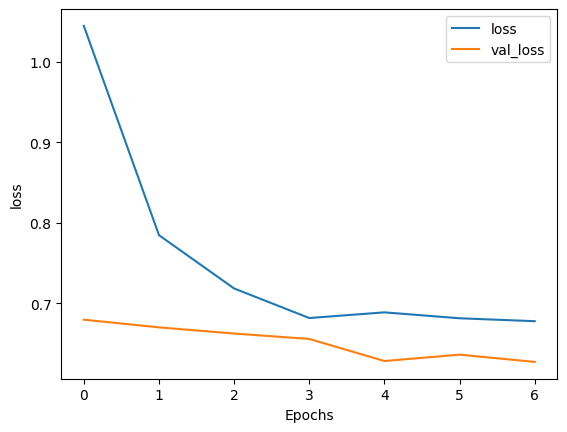

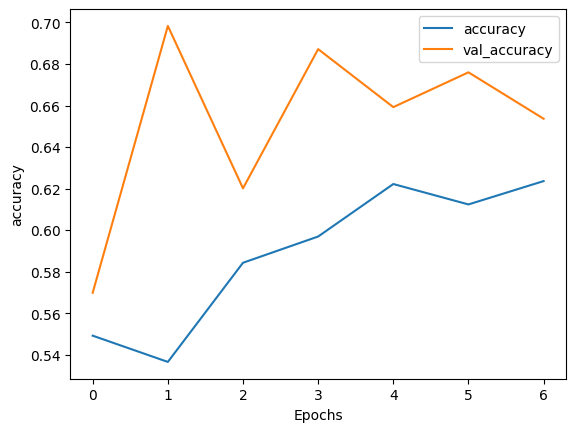

In [34]:
plot_metrics(history_nn_1)

In [35]:
print(train_ds.element_spec)
print(val_ds.element_spec)
print(test_ds.element_spec)

(TensorSpec(shape=(None, 8), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))
(TensorSpec(shape=(None, 8), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))
TensorSpec(shape=(None, 8), dtype=tf.float64, name=None)


In [36]:
preds_model_nn_1 = (model_nn_1.predict(val_ds) > 0.5).astype(np.int64).flatten()
accuracy_model_nn_1 = accuracy_score(preds_model_nn_1, val_target)
print(accuracy_model_nn_1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
0.4748603351955307


In [37]:
preds_model_nn_1 = (model_nn_1.predict(test_ds) > 0.5).astype(np.int64).flatten()
print(preds_model_nn_1[:10])

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
[0 0 0 0 0 0 0 1 0 1]


# Neural network model 2

In [38]:
model_nn_2 = keras.Sequential([
  layers.Dense(200, activation="relu"),
  layers.Dense(160, activation="relu"),
  layers.Dense(120, activation="relu"),
  layers.Dropout(0.5),
  layers.Dense(80, activation="relu"),
  layers.Dense(60, activation="relu"),
  layers.Dense(40, activation="relu"),
  layers.Dense(20, activation="relu"),
  layers.Dense(10, activation="relu"),
  layers.Dense(1, activation="sigmoid")
])

model_nn_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
               optimizer="adam",
               metrics=["accuracy"])

history_nn_2 = model_nn_2.fit(train_ds, 
                          epochs=EPOCHS, 
                          validation_data=val_ds, 
                          callbacks=callbacks)

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6486 - loss: 0.7075 
Epoch 1: val_accuracy improved from 0.69832 to 0.72626, saving model to /content/best_model.weights.h5
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6477 - loss: 0.7069 - val_accuracy: 0.7263 - val_loss: 0.6012 - learning_rate: 0.0010
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6887 - loss: 0.6376
Epoch 2: val_accuracy improved from 0.72626 to 0.75419, saving model to /content/best_model.weights.h5
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6878 - loss: 0.6384 - val_accuracy: 0.7542 - val_loss: 0.5918 - learning_rate: 0.0010
Epoch 3/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6250 - loss: 0.6600
Epoch 3: val_accuracy did not improve from 0.75419
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6339 - loss: 0.6551 - val_accuracy: 0.6480 - val_loss: 0.5969 - learning_rate: 0.0010
Epoch 4/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6250

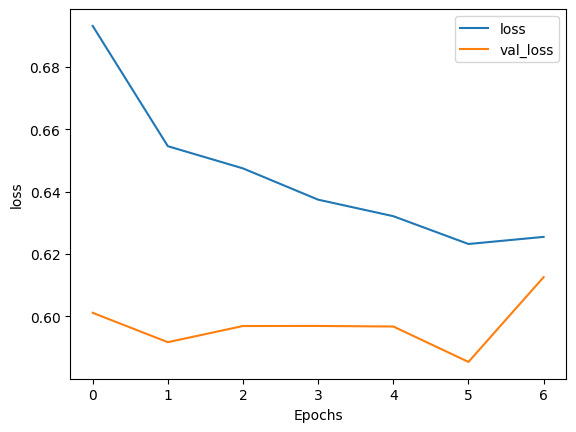

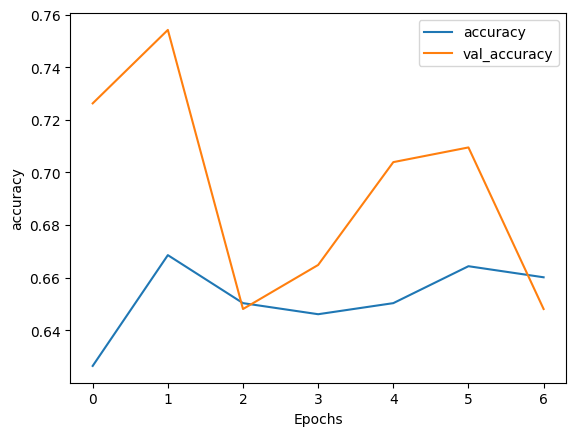

In [39]:
plot_metrics(history_nn_2)

In [40]:
preds_model_nn_2 = (model_nn_2.predict(val_ds) > 0.5).astype(np.int64).flatten()
accuracy_model_nn_2 = accuracy_score(preds_model_nn_2, val_target)
print(accuracy_model_nn_2)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
0.5083798882681564


In [41]:
preds_model_nn_2 = (model_nn_2.predict(test_ds) > 0.5).astype(np.int64).flatten()
print(preds_model_nn_2[:10])

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
[0 0 0 0 0 0 0 0 0 0]


# Compare models

In [42]:
results_df = {
    'standard_rf_model': standard_rf_accuracy,
    'minmax_rf_model': minmax_rf_accuracy,
    'robust_rf_model': robust_rf_accuracy,
    'standard_svm_model': standard_svc_accuracy,
    'minmax_svm_model': minmax_svc_accuracy,
    'robust_svm_model': robust_svc_accuracy,
    'standard_knn_model': standard_knn_accuracy,
    'minmax_knn_model': minmax_knn_accuracy,
    'robust_knn_model': robust_knn_accuracy,
    'xgb_model': xgb_accuracy,
    'xgb_rf_model': xgb_rf_accuracy,
    'model_nn_1': accuracy_model_nn_1,
    'model_nn_2': accuracy_model_nn_2,
}
results_df = pd.DataFrame(results_df.items(), columns=['Model', 'Accuracy'])
results_df.head()

,Model,Accuracy
0,standard_rf_model,0.804469
1,minmax_rf_model,0.787709
2,robust_rf_model,0.815642
3,standard_svm_model,0.798883
4,minmax_svm_model,0.793296


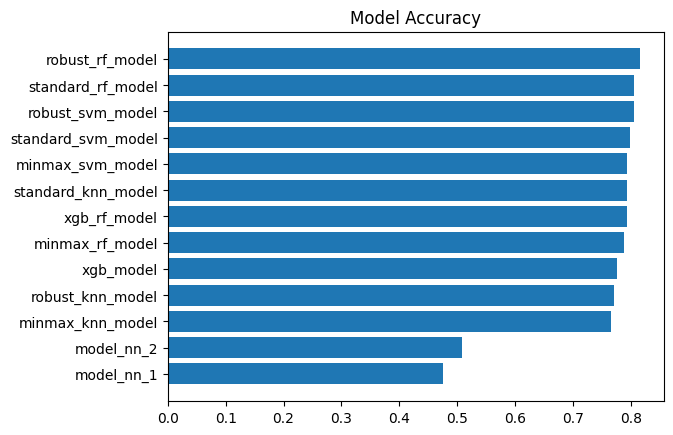

In [43]:
results_df = results_df.sort_values(by='Accuracy', ascending=False)
plt.barh(results_df.Model, results_df.Accuracy)
plt.title('Model Accuracy')
plt.gca().invert_yaxis()
plt.show()

# Submission

In [44]:
output = pd.DataFrame({'PassengerId': test_ids,
                       'Survived': minmax_rf_preds})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
